[View in Colaboratory](https://colab.research.google.com/github/alorozco53/SPY500-GAN/blob/master/SPY2_0.ipynb)

In [0]:
from google.colab import files

In [43]:
files.upload()

Saving spy-daily.csv to spy-daily (2).csv


{'spy-daily.csv': b'Date,Open,High,Low,Close,Adj Close,Volume\n1993-01-29,43.968700,43.968700,43.750000,43.937500,27.357281,1003200\n1993-02-01,43.968700,44.250000,43.968700,44.250000,27.551851,480500\n1993-02-02,44.218700,44.375000,44.125000,44.343700,27.610189,201300\n1993-02-03,44.406200,44.843700,44.375000,44.812500,27.902090,529400\n1993-02-04,44.968700,45.093700,44.468700,45.000000,28.018848,531500\n1993-02-05,44.968700,45.062500,44.718700,44.968700,27.999353,492100\n1993-02-08,44.968700,45.125000,44.906200,44.968700,27.999353,596100\n1993-02-09,44.812500,44.812500,44.562500,44.656200,27.804783,122100\n1993-02-10,44.656200,44.750000,44.531200,44.718700,27.843691,379600\n1993-02-11,44.781200,45.125000,44.781200,44.937500,27.979933,19500\n1993-02-12,44.875000,44.875000,44.593700,44.593700,27.765852,42500\n1993-02-16,44.468700,44.468700,43.406200,43.468700,27.065388,374800\n1993-02-17,43.468700,43.531200,43.281200,43.437500,27.045967,210900\n1993-02-18,43.937500,43.937500,42.812500,

In [0]:
from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, LSTM, RepeatVector, Input
from keras.layers.core import Activation, Dense, Reshape
from keras.layers.convolutional import Conv1D, MaxPooling1D, UpSampling1D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD
from keras import backend as K
from sklearn.preprocessing import MinMaxScaler
from random import randint

import keras
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd
import random
import sys
import os


In [0]:
## Stock model based on: https://github.com/jacobgil/keras-dcgan/blob/master/dcgan.py
def autoencoder(timesteps=128, input_dim=1):
    inputs = Input(shape=(timesteps, input_dim))
    encoded = LSTM(timesteps//2)(inputs)
    decoded = RepeatVector(timesteps)(encoded)
    decoded = LSTM(input_dim, return_sequences=True)(decoded)
    autoencoder = Model(inputs, decoded)
    autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
    autoencoder.summary()
    return autoencoder

In [0]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    df.columns = ['X', 'Y']
    return df

def generate_sample(dataset, size=128, batches=32):
    global scaler
    upper_bound = dataset.shape[0] - 1 - size
    sample = []
    for index in iter(randint(0, upper_bound) for _ in range(batches)):
        sample.append(dataset[index: index + size])
    sample = np.array(sample)
    if batches == 1:
        if len(sample.shape) < 2:
            sample = np.expand_dims(sample, axis=1)
        elif len(sample.shape) > 2:
            sample = sample.reshape((max(sample.shape), 1))
    else:
        sample = sample.squeeze()
    #print(sample.shape)
    sample = scaler.transform(sample)
    return np.expand_dims(sample, axis=len(sample.shape))

In [0]:
def train(data_file, out_loc, batch_size, epochs, lr_gen, lr_desc, lr_both):
    batch_size = int(batch_size)
    epochs = int(epochs)

    data = pd.read_csv(data_file, index_col='Date')
    data = data['Adj Close']
    mean = data.mean()
    x_true = generate_sample(data, size=730, batches=batch_size)
    sign = 2 * np.random.binomial(1, 0.5, size=x_true.shape) - 1
    noise = (np.random.uniform(0, 1, size=x_true.shape) * sign) + mean
    ae = autoencoder(timesteps=730)
    ae.fit(noise, x_true,
           epochs=epochs,
           batch_size=batch_size)
    return ae

In [125]:
data = pd.read_csv('spy-daily.csv', index_col='Date')
data = data['Adj Close']
scaler = MinMaxScaler()
scaler.fit(np.expand_dims(data, axis=1))

MinMaxScaler(copy=True, feature_range=(0, 1))

In [127]:
out_loc = 'logs/'
try:
  os.mkdir(out_loc)
except:
  pass
train('spy-daily.csv', out_loc, 32, 100, lr_gen=.01, lr_desc=0.0005, lr_both=0.0005)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 730, 1)            0         
_________________________________________________________________
lstm_37 (LSTM)               (None, 365)               535820    
_________________________________________________________________
repeat_vector_7 (RepeatVecto (None, 730, 365)          0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 730, 1)            1468      
Total params: 537,288
Trainable params: 537,288
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100


ResourceExhaustedError: ignored

In [0]:
import matplotlib.pyplot as plt

generator = gen_model_stock(max_time=730)
generator_file = 'logs/generator'
generator.load_weights(generator_file)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1460)              1067260   
_________________________________________________________________
activation_17 (Activation)   (None, 1460)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 1460)              2133060   
_________________________________________________________________
batch_normalization_3 (Batch (None, 1460)              5840      
_________________________________________________________________
activation_18 (Activation)   (None, 1460)              0         
_________________________________________________________________
reshape_3 (Reshape)          (None, 365, 4)            0         
_________________________________________________________________
up_sampling1d_5 (UpSampling1 (None, 730, 4)            0         
__________

106.11213828585372


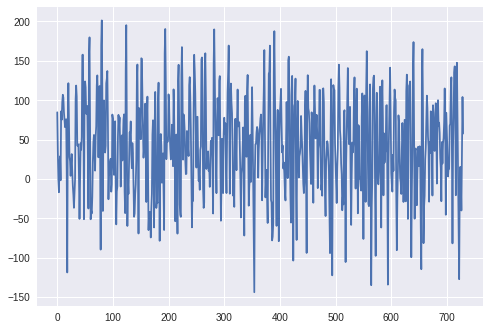

In [0]:
mean = data.mean()
sign = 2 * np.random.binomial(1, 0.5, size=(1, 730)) - 1
sample_input = (np.random.uniform(0, 1, size=(1, 730)) * sign) + mean
print(np.mean(sample_input))
sample_output = generator.predict(sample_input)
sample_output = sample_output.reshape((max(sample_output.shape), 1))
sample_output = scaler.inverse_transform(sample_output)
plt.plot(sample_output)

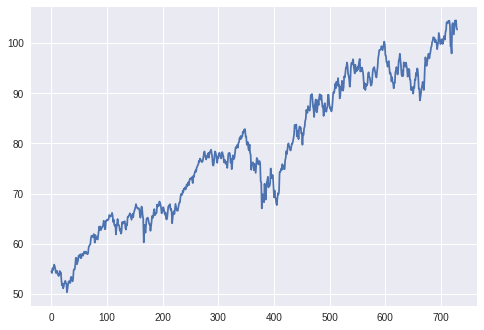

In [0]:
sample = generate_sample(data, size=730, batches=1)
sample = sample.reshape((max(sample.shape), 1))
sample = scaler.inverse_transform(sample)
plt.plot(sample)

In [0]:
# Install a Drive FUSE wrapper.
# https://github.com/astrada/google-drive-ocamlfuse
!apt-get update -qq 2>&1 > /dev/null
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse

Preconfiguring packages ...
Selecting previously unselected package cron.
(Reading database ... 18396 files and directories currently installed.)
Preparing to unpack .../00-cron_3.0pl1-128ubuntu5_amd64.deb ...
Unpacking cron (3.0pl1-128ubuntu5) ...
Selecting previously unselected package libapparmor1:amd64.
Preparing to unpack .../01-libapparmor1_2.11.0-2ubuntu17.1_amd64.deb ...
Unpacking libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Selecting previously unselected package libdbus-1-3:amd64.
Preparing to unpack .../02-libdbus-1-3_1.10.22-1ubuntu1_amd64.deb ...
Unpacking libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Selecting previously unselected package dbus.
Preparing to unpack .../03-dbus_1.10.22-1ubuntu1_amd64.deb ...
Unpacking dbus (1.10.22-1ubuntu1) ...
Preparing to unpack .../04-gnupg_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg (2.1.15-1ubuntu8.1) over (2.1.15-1ubuntu8) ...
Preparing to unpack .../05-gnupg-agent_2.1.15-1ubuntu8.1_amd64.deb ...
Unpacking gnupg-agent (2.1.15-1ubuntu8

Setting up libapparmor1:amd64 (2.11.0-2ubuntu17.1) ...
Setting up unattended-upgrades (0.98ubuntu1.1) ...

Creating config file /etc/apt/apt.conf.d/20auto-upgrades with new version

Creating config file /etc/apt/apt.conf.d/50unattended-upgrades with new version
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up gnupg-agent (2.1.15-1ubuntu8.1) ...
Setting up dirmngr (2.1.15-1ubuntu8.1) ...
Setting up cron (3.0pl1-128ubuntu5) ...
Adding group `crontab' (GID 102) ...
Done.
update-rc.d: warning: start and stop actions are no longer supported; falling back to defaults
update-rc.d: warning: stop runlevel arguments (1) do not match cron Default-Stop values (none)
invoke-rc.d: could not determine current runlevel
invoke-rc.d: policy-rc.d denied execution of start.
Setting up libdbus-1-3:amd64 (1.10.22-1ubuntu1) ...
Setting up kmod (24-1ubuntu2) ...
Setting up libdbus-glib-1-2:amd64 (0.108-2) ...
Setting up gnupg (2.1.15-1ubuntu8.1) 

In [0]:
# Generate auth tokens for Colab
from google.colab import auth
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
# Work around misordering of STREAM and STDIN in Jupyter.
# https://github.com/jupyter/notebook/issues/3159
prompt = !google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass(prompt[0] + '\n\nEnter verification code: ')
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force

Enter verification code: ··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.
!mkdir -p drive
!google-drive-ocamlfuse drive

In [0]:
!mkdir drive/spy500
!cp -R logs drive/spy500/